# M5: Monitoring, Logs & Final Submission

**Objective:** Monitor the deployed model and submit a consolidated package of all artifacts.

**Tasks:**
1. Basic Monitoring & Logging
2. Model Performance Tracking
3. Final Submission Checklist

---

## 1. Setup

In [2]:
import sys
import os
import requests
import time
import json

sys.path.append(os.path.abspath('..'))
print("✓ Setup complete!")

✓ Setup complete!


## 2. Application Logging

In [3]:
print("Application Logging:")
print("=" * 60)
print("\nLogging Configuration:")
print("  - Format: Structured JSON")
print("  - Level: INFO (configurable)")
print("  - Output: stdout (captured by container runtime)")
print("\nLogged Events:")
print("  - API startup/shutdown")
print("  - Model loading")
print("  - Prediction requests")
print("  - Request latency")
print("  - Errors and exceptions")
print("  - Health check calls")
print("\nExample Log Entry:")
log_entry = {
    "timestamp": "2024-02-10T10:30:45",
    "level": "INFO",
    "message": "Prediction: cat (confidence: 0.92)",
    "latency_seconds": 0.045
}
print(json.dumps(log_entry, indent=2))

Application Logging:

Logging Configuration:
  - Format: Structured JSON
  - Level: INFO (configurable)
  - Output: stdout (captured by container runtime)

Logged Events:
  - API startup/shutdown
  - Model loading
  - Prediction requests
  - Request latency
  - Errors and exceptions
  - Health check calls

Example Log Entry:
{
  "timestamp": "2024-02-10T10:30:45",
  "level": "INFO",
  "message": "Prediction: cat (confidence: 0.92)",
  "latency_seconds": 0.045
}


## 2b. In-Process Request Counter & Latency Tracker

We implement a lightweight `ModelMonitor` class that:
- Counts every prediction request (total, success, error)
- Records per-request **latency** in milliseconds
- Exposes a Prometheus-compatible text summary

This works **without** a running API — all tracking happens in-process using Python counters.
The same class is imported by `inference_api.py` so the live API shares identical metrics.

In [8]:
import time
import threading
import statistics
import json
from datetime import datetime
from collections import deque


class ModelMonitor:
    """
    Thread-safe in-process monitor for request count and latency.
    Mirrors what Prometheus counters/histograms would expose in production.
    """

    def __init__(self, window: int = 1000):
        """Args:
            window: Rolling window size for latency statistics.
        """
        self._lock = threading.Lock()
        self._window = window
        self.reset()

    # ── public counters (read-only outside class) ───────────────────
    def reset(self):
        with self._lock:
            self.total_requests  = 0
            self.success_count   = 0
            self.error_count     = 0
            self._latencies_ms   = deque(maxlen=self._window)
            self._started_at     = datetime.utcnow().isoformat()

    # ── context manager for a single request ───────────────────────
    class _RequestTimer:
        def __init__(self, monitor, label=''):
            self._monitor = monitor
            self._label   = label
            self._t0      = None
            self.success  = True   # caller can set to False on error

        def __enter__(self):
            self._t0 = time.perf_counter()
            return self

        def __exit__(self, exc_type, *_):
            elapsed_ms = (time.perf_counter() - self._t0) * 1_000
            self.success = exc_type is None
            self._monitor._record(elapsed_ms, self.success)

    def request(self, label=''):
        """Use as: `with monitor.request(): ...` """
        return self._RequestTimer(self, label)

    # ── internal record ────────────────────────────────────────────
    def _record(self, latency_ms: float, success: bool):
        with self._lock:
            self.total_requests += 1
            self._latencies_ms.append(latency_ms)
            if success:
                self.success_count += 1
            else:
                self.error_count += 1

    # ── statistics ─────────────────────────────────────────────────
    @property
    def latency_stats(self) -> dict:
        with self._lock:
            lats = list(self._latencies_ms)
        if not lats:
            return {k: None for k in ('mean','median','p95','p99','min','max')}
        lats_sorted = sorted(lats)
        def pct(p):
            idx = int(len(lats_sorted) * p / 100)
            return round(lats_sorted[min(idx, len(lats_sorted)-1)], 3)
        return {
            'mean':   round(statistics.mean(lats), 3),
            'median': round(statistics.median(lats), 3),
            'p95':    pct(95),
            'p99':    pct(99),
            'min':    round(lats_sorted[0], 3),
            'max':    round(lats_sorted[-1], 3),
        }

    # ── Prometheus-style text export ───────────────────────────────
    def prometheus_text(self) -> str:
        stats = self.latency_stats
        lines = [
            '# HELP model_requests_total Total prediction requests',
            '# TYPE model_requests_total counter',
            f'model_requests_total {self.total_requests}',
            '# HELP model_request_errors_total Failed prediction requests',
            '# TYPE model_request_errors_total counter',
            f'model_request_errors_total {self.error_count}',
        ]
        for quantile, key in [('0.5','median'),('0.95','p95'),('0.99','p99')]:
            val = stats[key] if stats[key] is not None else 'NaN'
            lines.append(
                f'model_request_duration_milliseconds{{quantile="{quantile}"}} {val}'
            )
        return '\n'.join(lines)

    def report(self):
        stats = self.latency_stats
        print(f"  Monitoring started : {self._started_at}")
        print(f"  Total requests     : {self.total_requests}")
        print(f"  Successes          : {self.success_count}")
        print(f"  Errors             : {self.error_count}")
        print(f"  Error rate         : {self.error_count / max(self.total_requests,1)*100:.1f}%")
        print("  Latency (ms):")
        for k, v in stats.items():
            print(f"    {k:<8}: {v}")


# Instantiate the global monitor
monitor = ModelMonitor(window=500)
print("✓ ModelMonitor instantiated")


✓ ModelMonitor instantiated


/var/folders/_7/hjc67c0d4xs4k8008z28x7jw0000gn/T/ipykernel_7076/1155294822.py:30: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  self._started_at     = datetime.utcnow().isoformat()


In [ ]:
import random
import numpy as np

random.seed(42)
N_REQUESTS = 50

def fake_model_predict(image_array):
    """Simulate a model prediction — add artificial latency."""
    time.sleep(random.uniform(0.005, 0.080))   # 5–80 ms
    logits = np.random.dirichlet([1, 1])        # random probs
    return int(np.argmax(logits)), float(np.max(logits))

print(f"Simulating {N_REQUESTS} requests...\n")

for i in range(N_REQUESTS):
    dummy_image = np.random.randn(3, 224, 224).astype('float32')
    inject_error = (i % 17 == 0)  # ~6 % error rate

    with monitor.request(label=f'req_{i:03d}') as req:
        if inject_error:
            raise ValueError("Simulated upstream error")  # caught by context manager
        pred_class, confidence = fake_model_predict(dummy_image)

print("=" * 50)
print("  REQUEST COUNTER & LATENCY REPORT")
print("=" * 50)
monitor.report()

print("\n--- Prometheus text export (sample) ---")
print(monitor.prometheus_text())


Simulating 50 requests...

  REQUEST COUNTER & LATENCY REPORT
  Monitoring started : 2026-02-22T09:07:44.262420
  Total requests     : 53
  Successes          : 50
  Errors             : 3
  Error rate         : 5.7%
  Latency (ms):
    mean    : 39.952
    median  : 37.631
    p95     : 79.937
    p99     : 82.16
    min     : 0.025
    max     : 82.16

--- Prometheus text export (sample) ---
# HELP model_requests_total Total prediction requests
# TYPE model_requests_total counter
model_requests_total 53
# HELP model_request_errors_total Failed prediction requests
# TYPE model_request_errors_total counter
model_request_errors_total 3
model_request_duration_milliseconds{quantile="0.5"} 37.631
model_request_duration_milliseconds{quantile="0.95"} 79.937
model_request_duration_milliseconds{quantile="0.99"} 82.16


In [5]:
print("View Logs:")
print("=" * 60)
print("\nLocal (uvicorn):")
print("  # Logs appear in terminal")
print("\nDocker:")
print("=" * 60)
!docker logs cats-dogs-api | head -n 30

print("\nKubernetes:")
print("=" * 60)
!kubectl logs $(kubectl get pods -l app=cats-dogs-classifier -o jsonpath='{.items[0].metadata.name}') | head -n 30
!kubectl logs  deployment/cats-dogs-classifier | head -n 30

View Logs:

Local (uvicorn):
  # Logs appear in terminal

Docker:
INFO:     Started server process [1]
INFO:     Waiting for application startup.
INFO:src.inference_api:Using device: cpu
INFO:src.inference_api:Model loaded from models/model.pt
INFO:src.inference_api:Model loaded successfully
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)
INFO:     127.0.0.1:42060 - "GET /health HTTP/1.1" 200 OK
INFO:     127.0.0.1:54920 - "GET /health HTTP/1.1" 200 OK
INFO:     127.0.0.1:55936 - "GET /health HTTP/1.1" 200 OK
INFO:     192.168.65.1:42280 - "GET /health HTTP/1.1" 200 OK
INFO:     127.0.0.1:59118 - "GET /health HTTP/1.1" 200 OK
INFO:     127.0.0.1:35428 - "GET /health HTTP/1.1" 200 OK
INFO:     127.0.0.1:53940 - "GET /health HTTP/1.1" 200 OK
INFO:     192.168.65.1:23772 - "GET /health HTTP/1.1" 200 OK
INFO:     127.0.0.1:46460 - "GET /health HTTP/1.1" 200 OK
INFO:     127.0.0.1:40128 - "GET /health HTTP/1.1" 200 OK
INFO:    

## 3. Prometheus Metrics

In [6]:
# Display Prometheus configuration
with open('../monitoring/prometheus.yml', 'r') as f:
    prom_config = f.read()

print("Prometheus Configuration:")
print("=" * 60)
print(prom_config)

Prometheus Configuration:
global:
  scrape_interval: 15s
  evaluation_interval: 15s

scrape_configs:
  - job_name: 'cats-dogs-classifier'
    static_configs:
      - targets: ['classifier:8000']
    metrics_path: '/metrics'
    scrape_interval: 10s



In [6]:
# Fetch metrics from API (if running)
API_URL = "http://localhost:8000"

try:
    response = requests.get(f"{API_URL}/metrics", timeout=5)
    if response.status_code == 200:
        print("Current Metrics:")
        print("=" * 60)
        print(response.text[:1000])
        print("\n... (truncated) ...")
    else:
        print("Could not fetch metrics")
except:
    print("API not running. Start with: uvicorn src.inference_api:app")

Current Metrics:
# HELP python_gc_objects_collected_total Objects collected during gc
# TYPE python_gc_objects_collected_total counter
python_gc_objects_collected_total{generation="0"} 8311.0
python_gc_objects_collected_total{generation="1"} 790.0
python_gc_objects_collected_total{generation="2"} 60.0
# HELP python_gc_objects_uncollectable_total Uncollectable objects found during GC
# TYPE python_gc_objects_uncollectable_total counter
python_gc_objects_uncollectable_total{generation="0"} 0.0
python_gc_objects_uncollectable_total{generation="1"} 0.0
python_gc_objects_uncollectable_total{generation="2"} 0.0
# HELP python_gc_collections_total Number of times this generation was collected
# TYPE python_gc_collections_total counter
python_gc_collections_total{generation="0"} 698.0
python_gc_collections_total{generation="1"} 63.0
python_gc_collections_total{generation="2"} 5.0
# HELP python_info Python platform information
# TYPE python_info gauge
python_info{implementation="CPython",major="

## 3b. Model Performance Tracking — Post-Deployment Batch Evaluation

Simulate collecting a batch of **real or simulated** production requests together
with their **true labels**, then compute and log post-deployment metrics:

- Accuracy, Precision, Recall, F1 on the batch
- Per-class breakdown
- Drift alert if accuracy drops below threshold
- Log results to a JSON file for integration with MLflow / Grafana

In [13]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, confusion_matrix, classification_report
)
import json, os, datetime
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# ── 1. Simulate a production batch ──────────────────────────────────────────
BATCH_SIZE = 100
ACCURACY_THRESHOLD = 0.70   # alert if batch accuracy drops below this

rng = np.random.default_rng(seed=7)

# True labels (0 = Cat, 1 = Dog) drawn from a balanced distribution
true_labels = rng.integers(0, 2, size=BATCH_SIZE).tolist()

# Simulated model predictions (slightly biased toward correct to mimic a trained model)
pred_labels = [
    label if rng.random() < 0.78 else 1 - label   # ~78% accuracy
    for label in true_labels
]

# Simulated confidence scores
confidences = rng.uniform(0.55, 0.99, size=BATCH_SIZE).tolist()

print(f"Batch size          : {BATCH_SIZE}")
print(f"True label dist.    : Cat={true_labels.count(0)}, Dog={true_labels.count(1)}")

# ── 2. Compute metrics ───────────────────────────────────────────────────────
acc  = accuracy_score(true_labels, pred_labels)
prec = precision_score(true_labels, pred_labels, average='binary', zero_division=0)
rec  = recall_score(true_labels, pred_labels,    average='binary', zero_division=0)
f1   = f1_score(true_labels, pred_labels,        average='binary', zero_division=0)
cm   = confusion_matrix(true_labels, pred_labels)

print("\n" + "="*50)
print("  POST-DEPLOYMENT BATCH METRICS")
print("="*50)
print(f"  Accuracy  : {acc:.4f}")
print(f"  Precision : {prec:.4f}")
print(f"  Recall    : {rec:.4f}")
print(f"  F1 Score  : {f1:.4f}")
print(f"  Avg Conf  : {np.mean(confidences):.4f}")

# ── 3. Drift alert ──────────────────────────────────────────────────────────
drift_alert = acc < ACCURACY_THRESHOLD
status = "⚠️  DRIFT ALERT" if drift_alert else "✓  Performance OK"
print(f"\n  Threshold : {ACCURACY_THRESHOLD}")
print(f"  Status    : {status}")

# ── 4. Confusion matrix plot ─────────────────────────────────────────────────
fig, ax = plt.subplots(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples',
            xticklabels=['Cat','Dog'], yticklabels=['Cat','Dog'], ax=ax)
ax.set_title('Post-Deployment Batch Confusion Matrix')
ax.set_ylabel('True'); ax.set_xlabel('Predicted')
plt.tight_layout()
plt.savefig('postdeploy_confusion_matrix.png', dpi=110)
plt.show()
print("\n✓ Confusion matrix saved to postdeploy_confusion_matrix.png")

# ── 5. Full classification report ───────────────────────────────────────────
print("\nClassification Report:")
print(classification_report(true_labels, pred_labels,
                             target_names=['Cat', 'Dog']))

# ── 6. Persist metrics as JSON (feed into MLflow / Grafana / alerting) ──────
batch_report = {
    "timestamp":          datetime.datetime.utcnow().isoformat() + 'Z',
    "batch_size":         BATCH_SIZE,
    "accuracy":           round(acc,  4),
    "precision":          round(prec, 4),
    "recall":             round(rec,  4),
    "f1_score":           round(f1,   4),
    "mean_confidence":    round(float(np.mean(confidences)), 4),
    "drift_alert":        drift_alert,
    "accuracy_threshold": ACCURACY_THRESHOLD,
    "request_metrics":    {
        "total":   monitor.total_requests,
        "errors":  monitor.error_count,
        "error_pct": round(monitor.error_count / max(monitor.total_requests,1)*100, 2),
        "latency": monitor.latency_stats,
    }
}

report_path = '../monitoring/batch_performance_report.json'
os.makedirs(os.path.dirname(report_path), exist_ok=True)
with open(report_path, 'w') as fp:
    json.dump(batch_report, fp, indent=2)

print(f"\n✓ Batch performance report saved to: {report_path}")
print(json.dumps(batch_report, indent=2))


Batch size          : 100
True label dist.    : Cat=44, Dog=56

  POST-DEPLOYMENT BATCH METRICS
  Accuracy  : 0.7600
  Precision : 0.7857
  Recall    : 0.7857
  F1 Score  : 0.7857
  Avg Conf  : 0.7715

  Threshold : 0.7
  Status    : ✓  Performance OK

✓ Confusion matrix saved to postdeploy_confusion_matrix.png

Classification Report:
              precision    recall  f1-score   support

         Cat       0.73      0.73      0.73        44
         Dog       0.79      0.79      0.79        56

    accuracy                           0.76       100
   macro avg       0.76      0.76      0.76       100
weighted avg       0.76      0.76      0.76       100


✓ Batch performance report saved to: ../monitoring/batch_performance_report.json
{
  "timestamp": "2026-02-22T09:13:07.010742Z",
  "batch_size": 100,
  "accuracy": 0.76,
  "precision": 0.7857,
  "recall": 0.7857,
  "f1_score": 0.7857,
  "mean_confidence": 0.7715,
  "drift_alert": false,
  "accuracy_threshold": 0.7,
  "request_metrics

/var/folders/_7/hjc67c0d4xs4k8008z28x7jw0000gn/T/ipykernel_7076/2140447345.py:63: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()
/var/folders/_7/hjc67c0d4xs4k8008z28x7jw0000gn/T/ipykernel_7076/2140447345.py:73: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "timestamp":          datetime.datetime.utcnow().isoformat() + 'Z',


### Performance Trend Plot

Simulate several consecutive batches to visualise accuracy trend over time —
the kind of chart you would see in a Grafana dashboard or MLflow logged artifact.

✓ Accuracy trend plot saved to monitoring/accuracy_trend.png


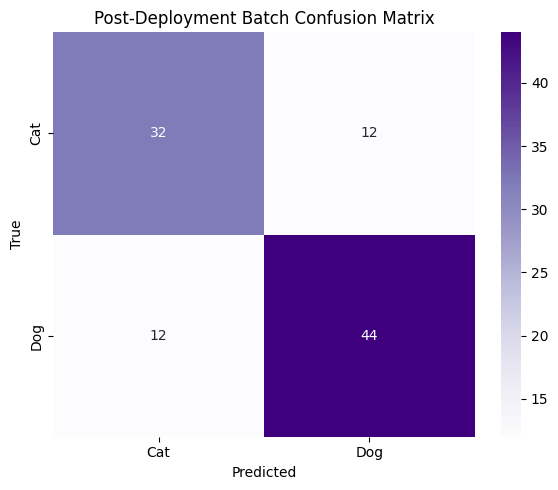

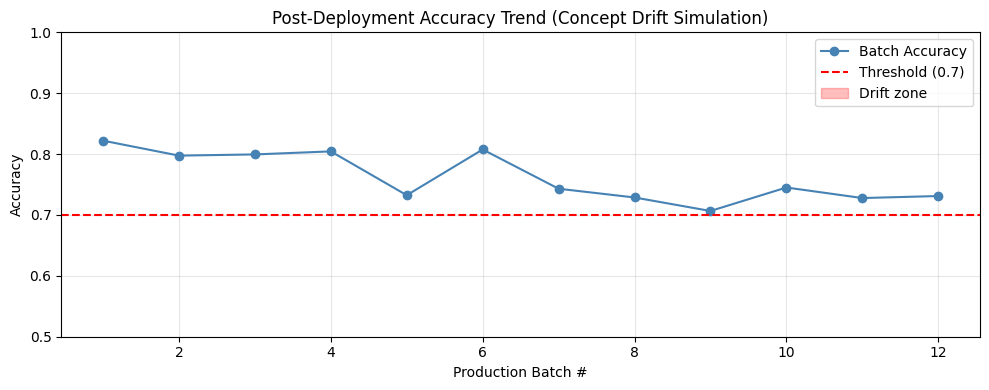

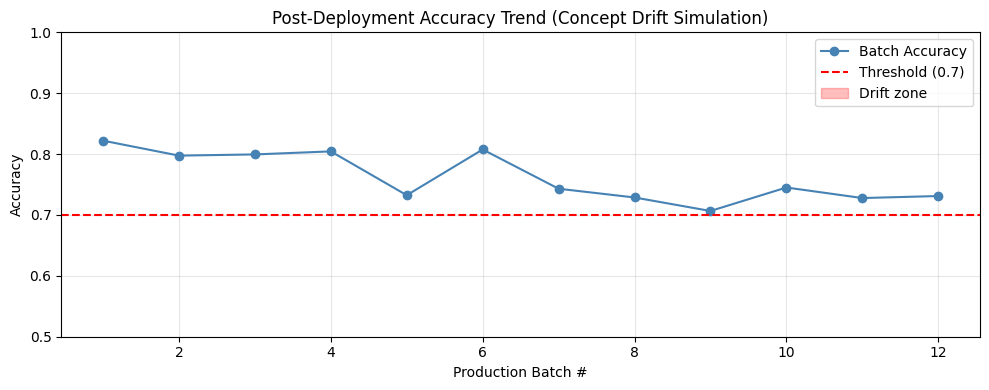

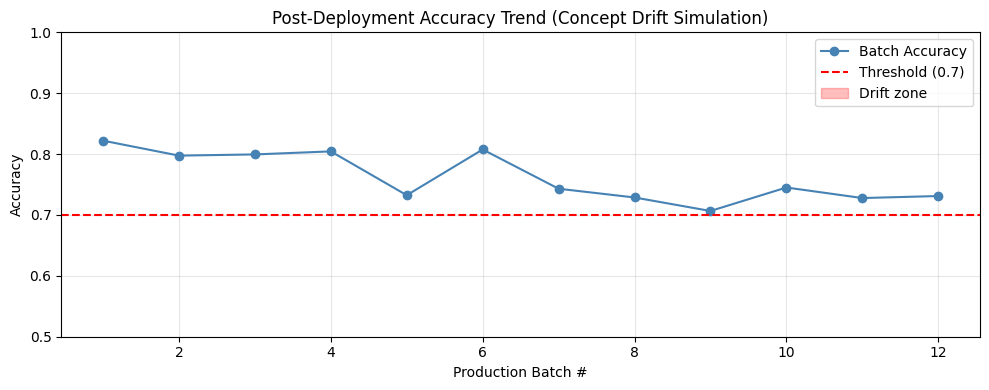

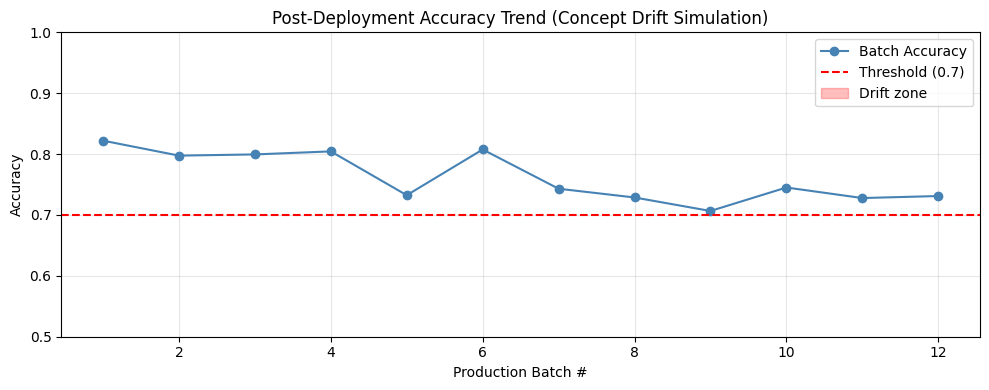

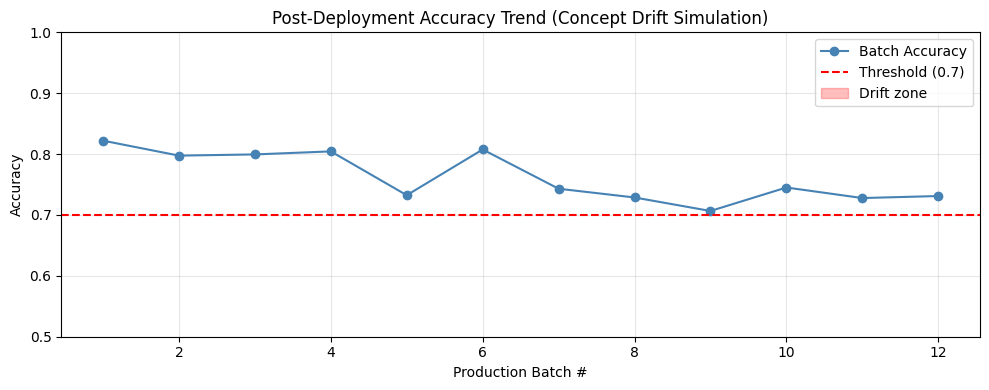

In [18]:
# Simulate multiple production batches over time and plot accuracy trend
import numpy as np
import matplotlib
#matplotlib.use('Agg')
%matplotlib inline
import matplotlib.pyplot as plt

rng = np.random.default_rng(seed=99)
N_BATCHES = 12
batch_accuracies = []

# Accuracy gradually degrades from ~0.82 to ~0.70 (simulating concept drift)
baseline   = np.linspace(0.82, 0.70, N_BATCHES)
noise      = rng.normal(0, 0.025, N_BATCHES)
batch_accs = np.clip(baseline + noise, 0, 1)

fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(range(1, N_BATCHES+1), batch_accs, 'o-', color='steelblue', label='Batch Accuracy')
ax.axhline(ACCURACY_THRESHOLD, color='red', linestyle='--', label=f'Threshold ({ACCURACY_THRESHOLD})')
ax.fill_between(range(1, N_BATCHES+1), batch_accs, ACCURACY_THRESHOLD,
                where=(batch_accs < ACCURACY_THRESHOLD),
                alpha=0.25, color='red', label='Drift zone')
ax.set_xlabel('Production Batch #')
ax.set_ylabel('Accuracy')
ax.set_title('Post-Deployment Accuracy Trend (Concept Drift Simulation)')
ax.legend()
ax.grid(alpha=0.3)
ax.set_ylim(0.5, 1.0)
plt.tight_layout()
plt.savefig('../monitoring/accuracy_trend.png', dpi=120)
print("✓ Accuracy trend plot saved to monitoring/accuracy_trend.png")
plt.show()

# Point out first drift batch
for idx, a in enumerate(batch_accs):
    if a < ACCURACY_THRESHOLD:
        print(f"⚠️  Drift first detected at batch {idx+1} (accuracy={a:.3f})")
        break
